In [237]:
#!pip install -q numpy==1.26.4

In [267]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import torch
import torch.nn as nn
import optuna
import lightgbm as lgb

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix, precision_score
from sklearn.ensemble import RandomForestClassifier
from phik import phik_matrix
from sqlalchemy import create_engine

In [239]:
warnings.filterwarnings('ignore')

In [ ]:
RANDOM_STATE = 0
TEST_SIZE = 0.2
torch.manual_seed(RANDOM_STATE)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [241]:
print(torch.cuda.is_available())

True


In [242]:
def get_data() -> pd.DataFrame:
    try:
        db_config = {
            'user': 'praktikum_student',
            'pwd': 'Sdf4$2;d-d30pp', 
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
            'port': 6432,
            'db': 'data-science-vehicle-db'
        } 
        connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
            db_config['user'],
            db_config['pwd'],
            db_config['host'],
            db_config['port'],
            db_config['db']
        )
        engine = create_engine(connection_string)
        
        query = '''
            SELECT
                c.*,
                p.party_number, p.at_fault, p.insurance_premium, p.party_sobriety, p.party_drug_physical, p.cellphone_in_use,
                v.vehicle_type, v.vehicle_transmission, v.vehicle_age
            FROM
                collisions c
            INNER JOIN
                parties p ON c.case_id = p.case_id
            INNER JOIN
                vehicles v ON c.case_id = v.case_id
            WHERE
                c.collision_date BETWEEN '2012-01-01' AND '2012-12-31'
                AND c.collision_damage != 'scratch'
                AND p.party_type = 'car';
        '''
        data = pd.read_sql_query(query, con=engine)
        return data
    except Exception as e:
        print(f'Error: {e}')
        return None

In [243]:
data = get_data()

In [244]:
data = data.drop_duplicates()
data.case_id = data.case_id.astype('int')
data = data[data['distance'] < 4000.0]
data.direction = data.direction.fillna('unknown').astype('category')
data.intersection = data.intersection.apply(lambda x: 'Y' if x == 1. else 
                                                      'N' if x == 0 else x).fillna('unknown').astype('category')
data.weather_1 = data.weather_1.fillna('unknown').astype('category')
data.location_type = data.location_type.fillna('unknown').astype('category')
data.collision_damage = data.collision_damage.astype('category')
data.party_count = data.party_count.apply(lambda x: '5+' if x > 4 else x).apply(
    lambda x: 'one' if x == 1 else
              'two' if x == 2 else
              'three' if x == 3 else
              'four' if x == 4 else
              'five_plus' if str(x) == '5+' else x).astype('category')
data.primary_collision_factor = data.primary_collision_factor.fillna('unknown').astype('category')
data.pcf_violation_category = data.pcf_violation_category.fillna('unknown').astype('category')
data.type_of_collision = data.type_of_collision.fillna('other').astype('category')
data.motor_vehicle_involved_with = data.motor_vehicle_involved_with.fillna('unknown').astype('category')
data.road_surface = data.road_surface.fillna('unknown').astype('category')
data.road_condition_1 = data.road_condition_1.fillna('other').astype('category')
data.lighting = data.lighting.fillna('unknown').astype('category')
data.control_device = data.control_device.fillna('unknown').astype('category')
data.collision_date = pd.to_datetime(data.collision_date)
data['collision_month'] = data.collision_date.dt.month
data['collision_day'] = data.collision_date.dt.day
data.collision_time = pd.to_datetime(data.collision_time, format='%H:%M:%S')
data['collision_hour'] = data.collision_time.dt.hour
data.party_number = data.party_number.apply(lambda x: '5+' if x > 4 else x).apply(
    lambda x: 'one' if x == 1 else
              'two' if x == 2 else
              'three' if x == 3 else
              'four' if x == 4 else
              'five_plus' if str(x) == '5+' else x).astype('category')
data.at_fault = data.at_fault.astype('category')
data.party_sobriety = data.party_sobriety.fillna('unknown').astype('category')
data.party_drug_physical = data.party_drug_physical.fillna('unknown').astype('category')
data.cellphone_in_use = data.cellphone_in_use.fillna('3.0').apply(
    lambda x: 'no' if x == 0 else
              'yes' if x == 1 else
              'unknown' if x == 3 else x).astype('category')
data.vehicle_type = data.vehicle_type.astype('category')
data.vehicle_transmission = data.vehicle_transmission.fillna('unknown').astype('category')
data = data[data['vehicle_age'] < 161.0]
data['insurance_premium'] = data['insurance_premium'].fillna(-1)
data['collision_hour'] = data['collision_hour'].interpolate()
data.at_fault = data.at_fault.astype('int')


In [245]:
# report = sv.analyze(data)
# report.show_notebook()

In [246]:
# plt.figure(figsize=(15, 13))
# sns.heatmap(phik_matrix(data[[
#     'county_location',
#     'intersection',
#     'weather_1',
#     'location_type',
#     'collision_damage',
#     'party_count',
#     'primary_collision_factor',
#     'pcf_violation_category',
#     'type_of_collision',
#     'motor_vehicle_involved_with',
#     'road_surface',
#     'road_condition_1',
#     'lighting',
#     'control_device',
#     'party_number',
#     'at_fault',
#     'party_sobriety',
#     'party_drug_physical',
#     'cellphone_in_use',
#     'vehicle_transmission',
# ]], interval_cols=['distance', 'insurance_premium', 'vehicle_age', 'collision_month', 'collision_day', 'collision_hour']), annot=True, cmap='coolwarm')
# plt.show()

In [247]:
num_cols = [
    'distance', 
    'insurance_premium', 
    'vehicle_age', 
    'collision_month', 
    'collision_day', 
    'collision_hour'
]
cat_cols = [
    'county_location',
    'intersection',
    'weather_1',
    'location_type',
    'collision_damage',
    'party_count',
    'primary_collision_factor',
    'pcf_violation_category',
    'type_of_collision',
    'motor_vehicle_involved_with',
    'road_surface',
    'road_condition_1',
    'lighting',
    'control_device',
    'party_number',
    'party_sobriety',
    'party_drug_physical',
    'cellphone_in_use',
    'vehicle_transmission'
]
all_colls = num_cols + cat_cols

In [248]:
X = data[all_colls]
y = data.at_fault

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y)

In [249]:
def data_preporation(
        numeric_cols: list = num_cols,
        category_cols: list = cat_cols,
        X_train: pd.DataFrame = X_train,
        X_test: pd.DataFrame = X_test
) -> tuple[pd.DataFrame, pd.DataFrame]:
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_cols),
        ('cat', OrdinalEncoder(
            handle_unknown='use_encoded_value', 
            unknown_value=np.nan                     
        ), category_cols)
    ], remainder='passthrough')

    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    feature_names = preprocessor.get_feature_names_out()
    X_train = pd.DataFrame(X_train_processed, columns=feature_names)
    X_test = pd.DataFrame(X_test_processed, columns=feature_names)
    return X_train, X_test

X_train, X_test = data_preporation()

In [250]:
X_train_torch = torch.FloatTensor(X_train.values).to(device)
X_test_torch = torch.FloatTensor(X_test.values).to(device)
y_train_torch = torch.FloatTensor(y_train.values).to(device)
y_test_torch = torch.FloatTensor(y_test.values).to(device)

train_dataset_torch = TensorDataset(X_train_torch, y_train_torch)
test_dataset_torch = TensorDataset(X_test_torch, y_test_torch)

## Написание модели pytorch

In [251]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_units, dropout_rate):
        super(Net, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_units, hidden_units//2),
            nn.BatchNorm1d(hidden_units//2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_units//2, hidden_units//4),
            nn.BatchNorm1d(hidden_units//4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_units//4, hidden_units//8),
            nn.BatchNorm1d(hidden_units//8),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_units//8, 1),
            #nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
def objective(trial):
    params = {
        'hidden_units': trial.suggest_categorical('hidden_units', [256, 512, 1024, 2048]),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256, 512, 1024, 2048])
    }

    print(f"\n=== Starting Trial {trial.number} ===")
    print(f"Parameters: {params}")

    train_loader = DataLoader(train_dataset_torch,
                              batch_size=params['batch_size'],
                              shuffle=True)
    
    net = Net(
        input_size=X_train.shape[1],
        hidden_units=params['hidden_units'],
        dropout_rate=params['dropout_rate']
    ).to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=params['lr'])
    loss_fn = nn.BCEWithLogitsLoss()

    best_f1 = 0
    patience = 20
    no_improve = 0
    num_epoch = 500

    for epoch in range(num_epoch):
        net.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            train_preds = net(inputs)
            train_loss = loss_fn(train_preds, labels.unsqueeze(1)) 
            train_loss.backward()
            optimizer.step()
        
        if epoch % 5 == 0 or epoch == num_epoch -1:
            net.eval()
            with torch.no_grad():
                test_inputs, test_labels = X_test_torch.to(device), y_test_torch.to(device)
                outputs = net(test_inputs)
                test_preds = (outputs > 0.5).float()
                test_f1 = f1_score(test_labels.cpu(), test_preds.cpu())
                
                if test_f1 > best_f1:
                    best_f1 = test_f1
                    no_improve = 0
                    best_epoch = epoch
                else:
                    no_improve += 1

                print(f"Trial {trial.number} | Epoch {epoch:3d} | "
                      f"Val F1: {test_f1:.4f} | Best F1: {best_f1:.4f} @ Epoch {best_epoch}")

                if no_improve >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

            trial.report(test_f1, epoch)
            if trial.should_prune():
                print(f"Pruned trial {trial.number} at epoch {epoch}")
                raise optuna.exceptions.TrialPruned()
            
    print(f"=== Completed Trial {trial.number} | Best F1: {best_f1:.4f} ===")
    return best_f1

In [253]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print(f'best params: {study.best_params}')
print(f'best f1: {study.best_value}')

[I 2025-02-17 17:10:54,209] A new study created in memory with name: no-name-8cdec45e-c17d-4241-8922-724659adcb10



=== Starting Trial 0 ===
Parameters: {'hidden_units': 512, 'dropout_rate': 0.10826708428322923, 'lr': 0.0007428955672438214, 'batch_size': 1024}
Trial 0 | Epoch   0 | Val F1: 0.8813 | Best F1: 0.8813 @ Epoch 0
Trial 0 | Epoch   5 | Val F1: 0.9068 | Best F1: 0.9068 @ Epoch 5
Trial 0 | Epoch  10 | Val F1: 0.9062 | Best F1: 0.9068 @ Epoch 5
Trial 0 | Epoch  15 | Val F1: 0.9064 | Best F1: 0.9068 @ Epoch 5
Trial 0 | Epoch  20 | Val F1: 0.9064 | Best F1: 0.9068 @ Epoch 5
Trial 0 | Epoch  25 | Val F1: 0.9078 | Best F1: 0.9078 @ Epoch 25
Trial 0 | Epoch  30 | Val F1: 0.9051 | Best F1: 0.9078 @ Epoch 25
Trial 0 | Epoch  35 | Val F1: 0.9043 | Best F1: 0.9078 @ Epoch 25
Trial 0 | Epoch  40 | Val F1: 0.9022 | Best F1: 0.9078 @ Epoch 25
Trial 0 | Epoch  45 | Val F1: 0.9085 | Best F1: 0.9085 @ Epoch 45
Trial 0 | Epoch  50 | Val F1: 0.9092 | Best F1: 0.9092 @ Epoch 50
Trial 0 | Epoch  55 | Val F1: 0.9069 | Best F1: 0.9092 @ Epoch 50
Trial 0 | Epoch  60 | Val F1: 0.9042 | Best F1: 0.9092 @ Epoch 50
T

[I 2025-02-17 17:11:31,951] Trial 0 finished with value: 0.9091620986687549 and parameters: {'hidden_units': 512, 'dropout_rate': 0.10826708428322923, 'lr': 0.0007428955672438214, 'batch_size': 1024}. Best is trial 0 with value: 0.9091620986687549.


Trial 0 | Epoch  75 | Val F1: 0.9032 | Best F1: 0.9092 @ Epoch 50
Early stopping at epoch 75
=== Completed Trial 0 | Best F1: 0.9092 ===

=== Starting Trial 1 ===
Parameters: {'hidden_units': 512, 'dropout_rate': 0.40840259766295695, 'lr': 0.005569605830395022, 'batch_size': 64}
Trial 1 | Epoch   0 | Val F1: 0.9048 | Best F1: 0.9048 @ Epoch 0
Trial 1 | Epoch   5 | Val F1: 0.9069 | Best F1: 0.9069 @ Epoch 5
Trial 1 | Epoch  10 | Val F1: 0.9064 | Best F1: 0.9069 @ Epoch 5
Trial 1 | Epoch  15 | Val F1: 0.9072 | Best F1: 0.9072 @ Epoch 15
Trial 1 | Epoch  20 | Val F1: 0.9054 | Best F1: 0.9072 @ Epoch 15
Trial 1 | Epoch  25 | Val F1: 0.9064 | Best F1: 0.9072 @ Epoch 15
Trial 1 | Epoch  30 | Val F1: 0.9068 | Best F1: 0.9072 @ Epoch 15
Trial 1 | Epoch  35 | Val F1: 0.9081 | Best F1: 0.9081 @ Epoch 35
Trial 1 | Epoch  40 | Val F1: 0.9071 | Best F1: 0.9081 @ Epoch 35
Trial 1 | Epoch  45 | Val F1: 0.9076 | Best F1: 0.9081 @ Epoch 35
Trial 1 | Epoch  50 | Val F1: 0.9079 | Best F1: 0.9081 @ Epoch 

[I 2025-02-17 17:13:43,058] Trial 1 finished with value: 0.90812611356418 and parameters: {'hidden_units': 512, 'dropout_rate': 0.40840259766295695, 'lr': 0.005569605830395022, 'batch_size': 64}. Best is trial 0 with value: 0.9091620986687549.


Trial 1 | Epoch  60 | Val F1: 0.9071 | Best F1: 0.9081 @ Epoch 35
Early stopping at epoch 60
=== Completed Trial 1 | Best F1: 0.9081 ===

=== Starting Trial 2 ===
Parameters: {'hidden_units': 1024, 'dropout_rate': 0.4834982006487968, 'lr': 0.00045652887620775776, 'batch_size': 128}
Trial 2 | Epoch   0 | Val F1: 0.8841 | Best F1: 0.8841 @ Epoch 0
Trial 2 | Epoch   5 | Val F1: 0.9061 | Best F1: 0.9061 @ Epoch 5
Trial 2 | Epoch  10 | Val F1: 0.9072 | Best F1: 0.9072 @ Epoch 10
Trial 2 | Epoch  15 | Val F1: 0.9065 | Best F1: 0.9072 @ Epoch 10
Trial 2 | Epoch  20 | Val F1: 0.9070 | Best F1: 0.9072 @ Epoch 10
Trial 2 | Epoch  25 | Val F1: 0.9059 | Best F1: 0.9072 @ Epoch 10
Trial 2 | Epoch  30 | Val F1: 0.9067 | Best F1: 0.9072 @ Epoch 10


[I 2025-02-17 17:14:26,785] Trial 2 finished with value: 0.907171853856563 and parameters: {'hidden_units': 1024, 'dropout_rate': 0.4834982006487968, 'lr': 0.00045652887620775776, 'batch_size': 128}. Best is trial 0 with value: 0.9091620986687549.


Trial 2 | Epoch  35 | Val F1: 0.9052 | Best F1: 0.9072 @ Epoch 10
Early stopping at epoch 35
=== Completed Trial 2 | Best F1: 0.9072 ===

=== Starting Trial 3 ===
Parameters: {'hidden_units': 1024, 'dropout_rate': 0.4048002198513767, 'lr': 0.0001806969882866472, 'batch_size': 512}
Trial 3 | Epoch   0 | Val F1: 0.8519 | Best F1: 0.8519 @ Epoch 0
Trial 3 | Epoch   5 | Val F1: 0.9037 | Best F1: 0.9037 @ Epoch 5
Trial 3 | Epoch  10 | Val F1: 0.9064 | Best F1: 0.9064 @ Epoch 10
Trial 3 | Epoch  15 | Val F1: 0.9072 | Best F1: 0.9072 @ Epoch 15
Trial 3 | Epoch  20 | Val F1: 0.9069 | Best F1: 0.9072 @ Epoch 15
Trial 3 | Epoch  25 | Val F1: 0.9066 | Best F1: 0.9072 @ Epoch 15
Trial 3 | Epoch  30 | Val F1: 0.9073 | Best F1: 0.9073 @ Epoch 30
Trial 3 | Epoch  35 | Val F1: 0.9063 | Best F1: 0.9073 @ Epoch 30
Trial 3 | Epoch  40 | Val F1: 0.9068 | Best F1: 0.9073 @ Epoch 30
Trial 3 | Epoch  45 | Val F1: 0.9069 | Best F1: 0.9073 @ Epoch 30
Trial 3 | Epoch  50 | Val F1: 0.9071 | Best F1: 0.9073 @ Epo

[I 2025-02-17 17:15:17,790] Trial 3 finished with value: 0.9078455790784558 and parameters: {'hidden_units': 1024, 'dropout_rate': 0.4048002198513767, 'lr': 0.0001806969882866472, 'batch_size': 512}. Best is trial 0 with value: 0.9091620986687549.


Trial 3 | Epoch  90 | Val F1: 0.9065 | Best F1: 0.9078 @ Epoch 65
Early stopping at epoch 90
=== Completed Trial 3 | Best F1: 0.9078 ===

=== Starting Trial 4 ===
Parameters: {'hidden_units': 512, 'dropout_rate': 0.24438004140536398, 'lr': 0.0002500790762101738, 'batch_size': 128}
Trial 4 | Epoch   0 | Val F1: 0.8820 | Best F1: 0.8820 @ Epoch 0
Trial 4 | Epoch   5 | Val F1: 0.9071 | Best F1: 0.9071 @ Epoch 5
Trial 4 | Epoch  10 | Val F1: 0.9069 | Best F1: 0.9071 @ Epoch 5
Trial 4 | Epoch  15 | Val F1: 0.9070 | Best F1: 0.9071 @ Epoch 5
Trial 4 | Epoch  20 | Val F1: 0.9072 | Best F1: 0.9072 @ Epoch 20
Trial 4 | Epoch  25 | Val F1: 0.9077 | Best F1: 0.9077 @ Epoch 25
Trial 4 | Epoch  30 | Val F1: 0.9054 | Best F1: 0.9077 @ Epoch 25
Trial 4 | Epoch  35 | Val F1: 0.9029 | Best F1: 0.9077 @ Epoch 25
Trial 4 | Epoch  40 | Val F1: 0.9042 | Best F1: 0.9077 @ Epoch 25
Trial 4 | Epoch  45 | Val F1: 0.9064 | Best F1: 0.9077 @ Epoch 25


[I 2025-02-17 17:16:19,711] Trial 4 finished with value: 0.9076767519639107 and parameters: {'hidden_units': 512, 'dropout_rate': 0.24438004140536398, 'lr': 0.0002500790762101738, 'batch_size': 128}. Best is trial 0 with value: 0.9091620986687549.


Trial 4 | Epoch  50 | Val F1: 0.9069 | Best F1: 0.9077 @ Epoch 25
Early stopping at epoch 50
=== Completed Trial 4 | Best F1: 0.9077 ===

=== Starting Trial 5 ===
Parameters: {'hidden_units': 512, 'dropout_rate': 0.3701225321724537, 'lr': 0.006810112279056998, 'batch_size': 1024}


[I 2025-02-17 17:16:20,320] Trial 5 pruned. 


Trial 5 | Epoch   0 | Val F1: 0.8725 | Best F1: 0.8725 @ Epoch 0
Pruned trial 5 at epoch 0

=== Starting Trial 6 ===
Parameters: {'hidden_units': 1024, 'dropout_rate': 0.22869671275095108, 'lr': 0.001760767610805796, 'batch_size': 128}
Trial 6 | Epoch   0 | Val F1: 0.9030 | Best F1: 0.9030 @ Epoch 0


[I 2025-02-17 17:16:27,584] Trial 6 pruned. 


Trial 6 | Epoch   5 | Val F1: 0.9063 | Best F1: 0.9063 @ Epoch 5
Pruned trial 6 at epoch 5

=== Starting Trial 7 ===
Parameters: {'hidden_units': 256, 'dropout_rate': 0.23433373328734333, 'lr': 0.0005633984181098431, 'batch_size': 256}


[I 2025-02-17 17:16:28,389] Trial 7 pruned. 


Trial 7 | Epoch   0 | Val F1: 0.8782 | Best F1: 0.8782 @ Epoch 0
Pruned trial 7 at epoch 0

=== Starting Trial 8 ===
Parameters: {'hidden_units': 512, 'dropout_rate': 0.11164779113797213, 'lr': 0.00015742933099520154, 'batch_size': 2048}


[I 2025-02-17 17:16:28,963] Trial 8 pruned. 


Trial 8 | Epoch   0 | Val F1: 0.8316 | Best F1: 0.8316 @ Epoch 0
Pruned trial 8 at epoch 0

=== Starting Trial 9 ===
Parameters: {'hidden_units': 2048, 'dropout_rate': 0.10387228631916368, 'lr': 0.00048058663784206505, 'batch_size': 1024}
Trial 9 | Epoch   0 | Val F1: 0.8994 | Best F1: 0.8994 @ Epoch 0


[I 2025-02-17 17:16:31,894] Trial 9 pruned. 


Trial 9 | Epoch   5 | Val F1: 0.9045 | Best F1: 0.9045 @ Epoch 5
Pruned trial 9 at epoch 5
best params: {'hidden_units': 512, 'dropout_rate': 0.10826708428322923, 'lr': 0.0007428955672438214, 'batch_size': 1024}
best f1: 0.9091620986687549


In [ ]:
best_params = study.best_params
final_model = Net(
    input_size=X_train.shape[1],
    hidden_units=best_params['hidden_units'],
    dropout_rate=best_params['dropout_rate']
).to(device)

optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['lr'])
train_loader = DataLoader(train_dataset_torch, 
                         batch_size=best_params['batch_size'], 
                         shuffle=True)
loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(200):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = loss_fn(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

final_model.eval()
with torch.no_grad():
    test_outputs = final_model(X_test_torch.to(device))
    predicted = (test_outputs > 0.5).float()
    final_f1 = f1_score(
        y_test_torch.cpu().numpy(), 
        predicted.cpu().numpy(),
        average='binary'
    )
    print(f"Final Test F1: {final_f1:.4f}")

Final Test F1: 0.9052


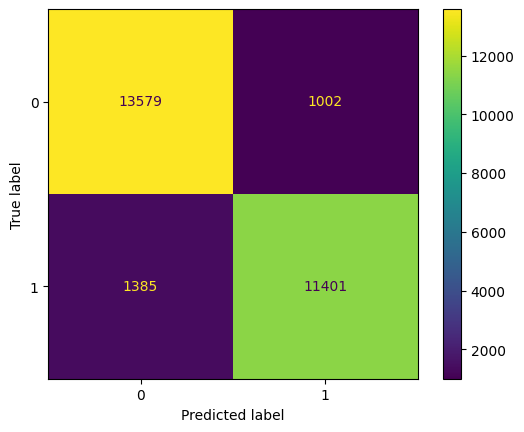

In [255]:
cm_pytorch = confusion_matrix(y_test_torch.cpu().numpy(), predicted.cpu().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_pytorch)
disp.plot()
plt.show()

In [256]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
        'feature_pre_filter': False,
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    callbacks = [
        lgb.log_evaluation(100),
        lgb.callback.early_stopping(500, verbose=False)
    ]

    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, test_data],
        num_boost_round=5000,
        callbacks=callbacks,
    )

    preds = model.predict(X_test)
    preds_binary = np.where(preds > 0.5, 1, 0)
    f1 = f1_score(y_test, preds_binary)

    print(f"\nTrial {trial.number} finished | Best F1: {f1:.4f}")
    print(f"Params: {params}\n")
    return f1


In [257]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best trial:")
trial = study.best_trial
print(f"  F1: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-02-17 17:17:21,932] A new study created in memory with name: no-name-41800246-550c-4845-9d81-0ec4d74d75d4


[100]	training's binary_logloss: 0.447398	valid_1's binary_logloss: 0.448802
[200]	training's binary_logloss: 0.336404	valid_1's binary_logloss: 0.339317
[300]	training's binary_logloss: 0.283949	valid_1's binary_logloss: 0.288436
[400]	training's binary_logloss: 0.259969	valid_1's binary_logloss: 0.265982
[500]	training's binary_logloss: 0.246973	valid_1's binary_logloss: 0.254525
[600]	training's binary_logloss: 0.23862	valid_1's binary_logloss: 0.24787
[700]	training's binary_logloss: 0.232767	valid_1's binary_logloss: 0.243816
[800]	training's binary_logloss: 0.22835	valid_1's binary_logloss: 0.2413
[900]	training's binary_logloss: 0.224696	valid_1's binary_logloss: 0.23951
[1000]	training's binary_logloss: 0.221307	valid_1's binary_logloss: 0.237836
[1100]	training's binary_logloss: 0.218466	valid_1's binary_logloss: 0.236577
[1200]	training's binary_logloss: 0.216013	valid_1's binary_logloss: 0.235779
[1300]	training's binary_logloss: 0.21377	valid_1's binary_logloss: 0.235239
[1

[I 2025-02-17 17:17:33,685] Trial 0 finished with value: 0.9159478590492399 and parameters: {'num_leaves': 80, 'learning_rate': 0.005970726709095896, 'max_depth': 11, 'min_child_samples': 126, 'subsample': 0.6303388910729372, 'colsample_bytree': 0.8719028049140097, 'reg_alpha': 1.0534649358022657e-07, 'reg_lambda': 0.07112406479074099}. Best is trial 0 with value: 0.9159478590492399.



Trial 0 finished | Best F1: 0.9159
Params: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'verbosity': -1, 'n_jobs': -1, 'feature_pre_filter': False, 'num_leaves': 80, 'learning_rate': 0.005970726709095896, 'max_depth': 11, 'min_child_samples': 126, 'subsample': 0.6303388910729372, 'colsample_bytree': 0.8719028049140097, 'reg_alpha': 1.0534649358022657e-07, 'reg_lambda': 0.07112406479074099}

[100]	training's binary_logloss: 0.625825	valid_1's binary_logloss: 0.626064
[200]	training's binary_logloss: 0.567928	valid_1's binary_logloss: 0.568369
[300]	training's binary_logloss: 0.524387	valid_1's binary_logloss: 0.52502
[400]	training's binary_logloss: 0.48668	valid_1's binary_logloss: 0.487504
[500]	training's binary_logloss: 0.456902	valid_1's binary_logloss: 0.457887
[600]	training's binary_logloss: 0.427942	valid_1's binary_logloss: 0.429115
[700]	training's binary_logloss: 0.402647	valid_1's binary_logloss: 0.404031
[800]	training's binary_logloss: 0.3

[I 2025-02-17 17:17:46,003] Trial 1 finished with value: 0.9127698188979418 and parameters: {'num_leaves': 285, 'learning_rate': 0.0017015180732586116, 'max_depth': 8, 'min_child_samples': 177, 'subsample': 0.8073491263937403, 'colsample_bytree': 0.5061584664416299, 'reg_alpha': 1.7089690383861378, 'reg_lambda': 8.722170972786296e-09}. Best is trial 0 with value: 0.9159478590492399.



Trial 1 finished | Best F1: 0.9128
Params: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'verbosity': -1, 'n_jobs': -1, 'feature_pre_filter': False, 'num_leaves': 285, 'learning_rate': 0.0017015180732586116, 'max_depth': 8, 'min_child_samples': 177, 'subsample': 0.8073491263937403, 'colsample_bytree': 0.5061584664416299, 'reg_alpha': 1.7089690383861378, 'reg_lambda': 8.722170972786296e-09}

[100]	training's binary_logloss: 0.425122	valid_1's binary_logloss: 0.428763
[200]	training's binary_logloss: 0.313671	valid_1's binary_logloss: 0.320373
[300]	training's binary_logloss: 0.268272	valid_1's binary_logloss: 0.278156
[400]	training's binary_logloss: 0.24316	valid_1's binary_logloss: 0.256788
[500]	training's binary_logloss: 0.228798	valid_1's binary_logloss: 0.246186
[600]	training's binary_logloss: 0.217915	valid_1's binary_logloss: 0.239656
[700]	training's binary_logloss: 0.209724	valid_1's binary_logloss: 0.235903
[800]	training's binary_logloss: 0.2

[I 2025-02-17 17:18:00,957] Trial 2 finished with value: 0.9182107140088379 and parameters: {'num_leaves': 210, 'learning_rate': 0.010108806307936086, 'max_depth': 11, 'min_child_samples': 128, 'subsample': 0.6026536815851116, 'colsample_bytree': 0.5330278959124615, 'reg_alpha': 5.169009238182572e-07, 'reg_lambda': 6.269347054625328e-06}. Best is trial 2 with value: 0.9182107140088379.



Trial 2 finished | Best F1: 0.9182
Params: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'verbosity': -1, 'n_jobs': -1, 'feature_pre_filter': False, 'num_leaves': 210, 'learning_rate': 0.010108806307936086, 'max_depth': 11, 'min_child_samples': 128, 'subsample': 0.6026536815851116, 'colsample_bytree': 0.5330278959124615, 'reg_alpha': 5.169009238182572e-07, 'reg_lambda': 6.269347054625328e-06}

[100]	training's binary_logloss: 0.593126	valid_1's binary_logloss: 0.593288
[200]	training's binary_logloss: 0.512627	valid_1's binary_logloss: 0.513014
[300]	training's binary_logloss: 0.455497	valid_1's binary_logloss: 0.456133
[400]	training's binary_logloss: 0.413491	valid_1's binary_logloss: 0.414345
[500]	training's binary_logloss: 0.383236	valid_1's binary_logloss: 0.384282
[600]	training's binary_logloss: 0.357486	valid_1's binary_logloss: 0.358758
[700]	training's binary_logloss: 0.336165	valid_1's binary_logloss: 0.337631
[800]	training's binary_logloss:

[I 2025-02-17 17:18:07,711] Trial 3 finished with value: 0.9121981328601189 and parameters: {'num_leaves': 144, 'learning_rate': 0.002522809518685607, 'max_depth': 4, 'min_child_samples': 113, 'subsample': 0.6094336293791294, 'colsample_bytree': 0.6513974903038373, 'reg_alpha': 0.041477346096715696, 'reg_lambda': 1.4171060311272304e-06}. Best is trial 2 with value: 0.9182107140088379.



Trial 3 finished | Best F1: 0.9122
Params: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'verbosity': -1, 'n_jobs': -1, 'feature_pre_filter': False, 'num_leaves': 144, 'learning_rate': 0.002522809518685607, 'max_depth': 4, 'min_child_samples': 113, 'subsample': 0.6094336293791294, 'colsample_bytree': 0.6513974903038373, 'reg_alpha': 0.041477346096715696, 'reg_lambda': 1.4171060311272304e-06}

[100]	training's binary_logloss: 0.272121	valid_1's binary_logloss: 0.277747
[200]	training's binary_logloss: 0.227684	valid_1's binary_logloss: 0.241476
[300]	training's binary_logloss: 0.214595	valid_1's binary_logloss: 0.235375
[400]	training's binary_logloss: 0.20776	valid_1's binary_logloss: 0.233336
[500]	training's binary_logloss: 0.201927	valid_1's binary_logloss: 0.232129
[600]	training's binary_logloss: 0.195214	valid_1's binary_logloss: 0.230955
[700]	training's binary_logloss: 0.189215	valid_1's binary_logloss: 0.230582
[800]	training's binary_logloss: 0

[I 2025-02-17 17:18:15,447] Trial 4 finished with value: 0.9188455271937311 and parameters: {'num_leaves': 283, 'learning_rate': 0.025081387483823527, 'max_depth': 9, 'min_child_samples': 145, 'subsample': 0.9550898766916156, 'colsample_bytree': 0.7268920502725447, 'reg_alpha': 7.0740483637421675e-06, 'reg_lambda': 6.152224715902488e-07}. Best is trial 4 with value: 0.9188455271937311.



Trial 4 finished | Best F1: 0.9188
Params: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'verbosity': -1, 'n_jobs': -1, 'feature_pre_filter': False, 'num_leaves': 283, 'learning_rate': 0.025081387483823527, 'max_depth': 9, 'min_child_samples': 145, 'subsample': 0.9550898766916156, 'colsample_bytree': 0.7268920502725447, 'reg_alpha': 7.0740483637421675e-06, 'reg_lambda': 6.152224715902488e-07}

[100]	training's binary_logloss: 0.461259	valid_1's binary_logloss: 0.464028
[200]	training's binary_logloss: 0.347647	valid_1's binary_logloss: 0.352702
[300]	training's binary_logloss: 0.295086	valid_1's binary_logloss: 0.302428
[400]	training's binary_logloss: 0.264103	valid_1's binary_logloss: 0.274022
[500]	training's binary_logloss: 0.246085	valid_1's binary_logloss: 0.25852
[600]	training's binary_logloss: 0.232919	valid_1's binary_logloss: 0.24842
[700]	training's binary_logloss: 0.223683	valid_1's binary_logloss: 0.242461
[800]	training's binary_logloss: 0

[I 2025-02-17 17:18:32,356] Trial 5 finished with value: 0.9170769528978484 and parameters: {'num_leaves': 227, 'learning_rate': 0.008014096562086735, 'max_depth': 11, 'min_child_samples': 153, 'subsample': 0.9465914004845847, 'colsample_bytree': 0.5155374498372467, 'reg_alpha': 1.2374276785546979e-05, 'reg_lambda': 2.2266105854750767e-08}. Best is trial 4 with value: 0.9188455271937311.



Trial 5 finished | Best F1: 0.9171
Params: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'verbosity': -1, 'n_jobs': -1, 'feature_pre_filter': False, 'num_leaves': 227, 'learning_rate': 0.008014096562086735, 'max_depth': 11, 'min_child_samples': 153, 'subsample': 0.9465914004845847, 'colsample_bytree': 0.5155374498372467, 'reg_alpha': 1.2374276785546979e-05, 'reg_lambda': 2.2266105854750767e-08}

[100]	training's binary_logloss: 0.631811	valid_1's binary_logloss: 0.631924
[200]	training's binary_logloss: 0.576812	valid_1's binary_logloss: 0.577092
[300]	training's binary_logloss: 0.530261	valid_1's binary_logloss: 0.530707
[400]	training's binary_logloss: 0.494093	valid_1's binary_logloss: 0.494681
[500]	training's binary_logloss: 0.463607	valid_1's binary_logloss: 0.464332
[600]	training's binary_logloss: 0.436548	valid_1's binary_logloss: 0.437418
[700]	training's binary_logloss: 0.411938	valid_1's binary_logloss: 0.412968
[800]	training's binary_loglos

[I 2025-02-17 17:18:41,070] Trial 6 finished with value: 0.9120734908136483 and parameters: {'num_leaves': 180, 'learning_rate': 0.0011672040278263845, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.6393156044677821, 'colsample_bytree': 0.7854052298386087, 'reg_alpha': 7.583461470867443, 'reg_lambda': 1.8487239743460054e-08}. Best is trial 4 with value: 0.9188455271937311.



Trial 6 finished | Best F1: 0.9121
Params: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'verbosity': -1, 'n_jobs': -1, 'feature_pre_filter': False, 'num_leaves': 180, 'learning_rate': 0.0011672040278263845, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.6393156044677821, 'colsample_bytree': 0.7854052298386087, 'reg_alpha': 7.583461470867443, 'reg_lambda': 1.8487239743460054e-08}

[100]	training's binary_logloss: 0.284044	valid_1's binary_logloss: 0.288645
[200]	training's binary_logloss: 0.241738	valid_1's binary_logloss: 0.250474
[300]	training's binary_logloss: 0.22842	valid_1's binary_logloss: 0.241539
[400]	training's binary_logloss: 0.220509	valid_1's binary_logloss: 0.237992
[500]	training's binary_logloss: 0.214756	valid_1's binary_logloss: 0.236419
[600]	training's binary_logloss: 0.209992	valid_1's binary_logloss: 0.235394
[700]	training's binary_logloss: 0.205642	valid_1's binary_logloss: 0.234539
[800]	training's binary_logloss: 0.20

[I 2025-02-17 17:18:49,457] Trial 7 finished with value: 0.9202306769361768 and parameters: {'num_leaves': 63, 'learning_rate': 0.017090862118390154, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.634900320605567, 'colsample_bytree': 0.9972260306836762, 'reg_alpha': 0.00025307708752477236, 'reg_lambda': 0.6666782654226472}. Best is trial 7 with value: 0.9202306769361768.



Trial 7 finished | Best F1: 0.9202
Params: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'verbosity': -1, 'n_jobs': -1, 'feature_pre_filter': False, 'num_leaves': 63, 'learning_rate': 0.017090862118390154, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.634900320605567, 'colsample_bytree': 0.9972260306836762, 'reg_alpha': 0.00025307708752477236, 'reg_lambda': 0.6666782654226472}

[100]	training's binary_logloss: 0.405973	valid_1's binary_logloss: 0.406653
[200]	training's binary_logloss: 0.320322	valid_1's binary_logloss: 0.321689
[300]	training's binary_logloss: 0.292993	valid_1's binary_logloss: 0.294725
[400]	training's binary_logloss: 0.282506	valid_1's binary_logloss: 0.28443
[500]	training's binary_logloss: 0.276131	valid_1's binary_logloss: 0.278235
[600]	training's binary_logloss: 0.271738	valid_1's binary_logloss: 0.273995
[700]	training's binary_logloss: 0.268088	valid_1's binary_logloss: 0.270543
[800]	training's binary_logloss: 0.265

[I 2025-02-17 17:18:54,749] Trial 8 finished with value: 0.9123064447619416 and parameters: {'num_leaves': 58, 'learning_rate': 0.008854599044284619, 'max_depth': 3, 'min_child_samples': 83, 'subsample': 0.7603064063519931, 'colsample_bytree': 0.9217153345925381, 'reg_alpha': 9.576815236454593, 'reg_lambda': 2.2839778599932607e-05}. Best is trial 7 with value: 0.9202306769361768.



Trial 8 finished | Best F1: 0.9123
Params: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'verbosity': -1, 'n_jobs': -1, 'feature_pre_filter': False, 'num_leaves': 58, 'learning_rate': 0.008854599044284619, 'max_depth': 3, 'min_child_samples': 83, 'subsample': 0.7603064063519931, 'colsample_bytree': 0.9217153345925381, 'reg_alpha': 9.576815236454593, 'reg_lambda': 2.2839778599932607e-05}

[100]	training's binary_logloss: 0.194785	valid_1's binary_logloss: 0.229206
[200]	training's binary_logloss: 0.164418	valid_1's binary_logloss: 0.224209
[300]	training's binary_logloss: 0.140243	valid_1's binary_logloss: 0.222214
[400]	training's binary_logloss: 0.119668	valid_1's binary_logloss: 0.220471
[500]	training's binary_logloss: 0.103687	valid_1's binary_logloss: 0.220267
[600]	training's binary_logloss: 0.0879121	valid_1's binary_logloss: 0.221189
[700]	training's binary_logloss: 0.0761724	valid_1's binary_logloss: 0.223039
[800]	training's binary_logloss: 0.0

[I 2025-02-17 17:18:57,243] Trial 9 finished with value: 0.9201736030380532 and parameters: {'num_leaves': 183, 'learning_rate': 0.08472780585043418, 'max_depth': 10, 'min_child_samples': 89, 'subsample': 0.6153434865648075, 'colsample_bytree': 0.7650217417850335, 'reg_alpha': 8.188040746890532e-05, 'reg_lambda': 9.276937143890487e-07}. Best is trial 7 with value: 0.9202306769361768.



Trial 9 finished | Best F1: 0.9202
Params: {'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt', 'verbosity': -1, 'n_jobs': -1, 'feature_pre_filter': False, 'num_leaves': 183, 'learning_rate': 0.08472780585043418, 'max_depth': 10, 'min_child_samples': 89, 'subsample': 0.6153434865648075, 'colsample_bytree': 0.7650217417850335, 'reg_alpha': 8.188040746890532e-05, 'reg_lambda': 9.276937143890487e-07}

Best trial:
  F1: 0.9202
  Params: 
    num_leaves: 63
    learning_rate: 0.017090862118390154
    max_depth: 10
    min_child_samples: 29
    subsample: 0.634900320605567
    colsample_bytree: 0.9972260306836762
    reg_alpha: 0.00025307708752477236
    reg_lambda: 0.6666782654226472


In [258]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

best_params = trial.params
best_params.update({
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'n_jobs': -1
})

final_model = lgb.train(
    best_params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
)

# Оценка на тестовых данных
test_preds = final_model.predict(X_test)
test_preds_binary = np.where(test_preds > 0.5, 1, 0)
final_f1 = f1_score(y_test, test_preds_binary)
print(f"\nFinal Test F1: {final_f1:.4f}")

Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.374548
[100]	valid_0's binary_logloss: 0.288645
[150]	valid_0's binary_logloss: 0.260902
[200]	valid_0's binary_logloss: 0.250474
[250]	valid_0's binary_logloss: 0.245223
[300]	valid_0's binary_logloss: 0.241539
[350]	valid_0's binary_logloss: 0.239187
[400]	valid_0's binary_logloss: 0.237992
[450]	valid_0's binary_logloss: 0.237217
[500]	valid_0's binary_logloss: 0.236419
[550]	valid_0's binary_logloss: 0.235783
[600]	valid_0's binary_logloss: 0.235394
[650]	valid_0's binary_logloss: 0.234945
[700]	valid_0's binary_logloss: 0.234539
[750]	valid_0's binary_logloss: 0.233974
[800]	valid_0's binary_logloss: 0.233681
[850]	valid_0's binary_logloss: 0.233239
[900]	valid_0's binary_logloss: 0.232909
[950]	valid_0's binary_logloss: 0.232628
[1000]	valid_0's binary_logloss: 0.23249
Did not meet early stopping. Best iteration is:
[988]	valid_0's binary_logloss: 0.232481

Final Test F1: 0.9144


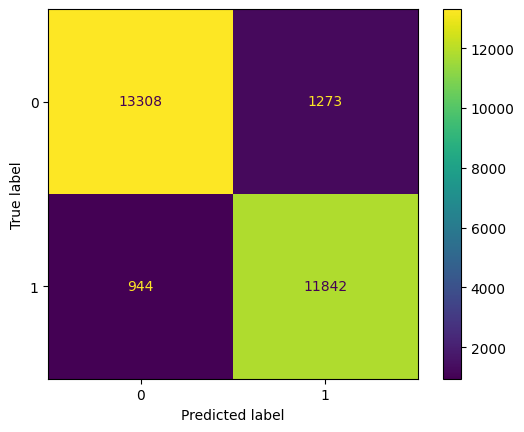

In [259]:
cm_lgb = confusion_matrix(y_test, test_preds_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lgb)
disp.plot()
plt.show()

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample'])
    }
    
    model = RandomForestClassifier(
        **params,
        random_state=42,
        n_jobs=-1
    )
    
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=3,
        scoring='f1_macro',
        n_jobs=-1
    )
    
    f1 = scores.mean()
    return f1

In [269]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600)

[I 2025-02-17 20:14:36,370] A new study created in memory with name: no-name-0f3e3a7a-16a6-4653-80a6-abbb81ae9e62
[I 2025-02-17 20:14:41,259] Trial 0 finished with value: 0.9178642542669717 and parameters: {'n_estimators': 234, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.9178642542669717.


Trial   0 | F1: 0.9179 | Params: {'n_estimators': 234, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced_subsample'}


[I 2025-02-17 20:14:47,576] Trial 1 finished with value: 0.9160903437920856 and parameters: {'n_estimators': 174, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.9178642542669717.
[I 2025-02-17 20:15:01,688] Trial 2 finished with value: 0.9135926332290856 and parameters: {'n_estimators': 232, 'max_depth': 12, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9178642542669717.
[I 2025-02-17 20:15:08,837] Trial 3 finished with value: 0.9133552464182312 and parameters: {'n_estimators': 463, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.9178642542669717.
[I 2025-02-17 20:15:11,241] Trial 4 finished with value: 0.9117814947430712 and paramet

Trial   5 | F1: 0.9102 | Params: {'n_estimators': 408, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced'}


[I 2025-02-17 20:15:41,290] Trial 6 finished with value: 0.9141164621204987 and parameters: {'n_estimators': 314, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9178642542669717.
[I 2025-02-17 20:15:42,448] Trial 7 finished with value: 0.9104854718059778 and parameters: {'n_estimators': 97, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.9178642542669717.
[I 2025-02-17 20:15:50,484] Trial 8 finished with value: 0.9183544373961471 and parameters: {'n_estimators': 228, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 8 with value: 0.9183544373961471.
[I 2025-02-17 20:15:53,448] Trial 9 finished with value: 0.9133583684502685 and parameters: {'n_estimat

Trial  10 | F1: 0.9181 | Params: {'n_estimators': 343, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': True, 'class_weight': None}


[I 2025-02-17 20:16:16,078] Trial 11 finished with value: 0.9180791702466355 and parameters: {'n_estimators': 361, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 8 with value: 0.9183544373961471.
[I 2025-02-17 20:16:27,141] Trial 12 finished with value: 0.9180190430713521 and parameters: {'n_estimators': 375, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 8 with value: 0.9183544373961471.
[I 2025-02-17 20:16:32,111] Trial 13 finished with value: 0.9167056018309397 and parameters: {'n_estimators': 183, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 8 with value: 0.9183544373961471.
[I 2025-02-17 20:16:47,191] Trial 14 finished with value: 0.9181159523594776 and parameters: {'n_estimators': 468, 'max_depth'

Trial  15 | F1: 0.8978 | Params: {'n_estimators': 458, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': True, 'class_weight': None}


[I 2025-02-17 20:17:10,350] Trial 16 finished with value: 0.9184633881141687 and parameters: {'n_estimators': 497, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 16 with value: 0.9184633881141687.
[I 2025-02-17 20:17:17,483] Trial 17 finished with value: 0.9185485204785341 and parameters: {'n_estimators': 175, 'max_depth': 12, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 17 with value: 0.9185485204785341.
[I 2025-02-17 20:17:19,036] Trial 18 finished with value: 0.9149177287067527 and parameters: {'n_estimators': 144, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True, 'class_weight': None}. Best is trial 17 with value: 0.9185485204785341.
[I 2025-02-17 20:17:23,054] Trial 19 finished with value: 0.9183012237685544 and parameters: {'n_estimators': 293, 'max

Trial  20 | F1: 0.9188 | Params: {'n_estimators': 126, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'class_weight': None}


[I 2025-02-17 20:17:33,980] Trial 21 finished with value: 0.9187935377350356 and parameters: {'n_estimators': 130, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 20 with value: 0.9188300801051219.
[I 2025-02-17 20:17:39,633] Trial 22 finished with value: 0.9187931167957345 and parameters: {'n_estimators': 131, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 20 with value: 0.9188300801051219.
[I 2025-02-17 20:17:44,951] Trial 23 finished with value: 0.9190348561134613 and parameters: {'n_estimators': 118, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 23 with value: 0.9190348561134613.
[I 2025-02-17 20:17:47,713] Trial 24 finished with value: 0.9198213960938348 and parameters: {'n_estimators': 56, 'max_depth

Trial  25 | F1: 0.9197 | Params: {'n_estimators': 60, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True, 'class_weight': None}


[I 2025-02-17 20:17:53,624] Trial 26 finished with value: 0.9202022752606327 and parameters: {'n_estimators': 62, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 26 with value: 0.9202022752606327.
[I 2025-02-17 20:17:57,048] Trial 27 finished with value: 0.920938934406589 and parameters: {'n_estimators': 70, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:17:58,207] Trial 28 finished with value: 0.9191296472349264 and parameters: {'n_estimators': 61, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced_subsample'}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:17:59,333] Trial 29 finished with value: 0.9166058274372347 and parameters: {'n_estimators': 84

Trial  30 | F1: 0.9189 | Params: {'n_estimators': 54, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced_subsample'}


[I 2025-02-17 20:18:02,739] Trial 31 finished with value: 0.9197346319688678 and parameters: {'n_estimators': 51, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:18:07,049] Trial 32 finished with value: 0.9194385269701547 and parameters: {'n_estimators': 95, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:18:16,381] Trial 33 finished with value: 0.9202494339205156 and parameters: {'n_estimators': 206, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:18:25,938] Trial 34 finished with value: 0.919733177705972 and parameters: {'n_estimators': 213, 'max_depth': 14

Trial  35 | F1: 0.9120 | Params: {'n_estimators': 151, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced_subsample'}


[I 2025-02-17 20:18:43,239] Trial 36 finished with value: 0.9189762659379762 and parameters: {'n_estimators': 196, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:18:50,557] Trial 37 finished with value: 0.9072582987385364 and parameters: {'n_estimators': 105, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:18:57,335] Trial 38 finished with value: 0.9190631222074123 and parameters: {'n_estimators': 156, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:19:01,069] Trial 39 finished with value: 0.9158248994968042 and parameters: {'n_estimators': 257, 'max_

Trial  40 | F1: 0.9194 | Params: {'n_estimators': 82, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced'}


[I 2025-02-17 20:19:07,181] Trial 41 finished with value: 0.9198326322021324 and parameters: {'n_estimators': 53, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:19:11,055] Trial 42 finished with value: 0.920188458951373 and parameters: {'n_estimators': 80, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:19:15,784] Trial 43 finished with value: 0.9196474087451149 and parameters: {'n_estimators': 105, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:19:19,589] Trial 44 finished with value: 0.9201620941216867 and parameters: {'n_estimators': 82, 'max_depth': 14,

Trial  45 | F1: 0.9184 | Params: {'n_estimators': 83, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'class_weight': None}


[I 2025-02-17 20:19:25,635] Trial 46 finished with value: 0.9191491703795064 and parameters: {'n_estimators': 108, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:19:32,015] Trial 47 finished with value: 0.9187810210953943 and parameters: {'n_estimators': 165, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:19:35,688] Trial 48 finished with value: 0.9194740288535178 and parameters: {'n_estimators': 78, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 27 with value: 0.920938934406589.
[I 2025-02-17 20:19:45,539] Trial 49 finished with value: 0.9211327754998432 and parameters: {'n_estimators': 212, 'max_depth': 

In [270]:
print("\nBest trial:")
trial = study.best_trial
print(f"  F1: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


Best trial:
  F1: 0.9211
  Params:
    n_estimators: 212
    max_depth: 15
    min_samples_split: 2
    min_samples_leaf: 1
    max_features: None
    bootstrap: True
    class_weight: None


In [271]:
best_params = study.best_params
final_model = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
).fit(X_train, y_train)

# Оценка
test_preds = final_model.predict(X_test)
final_f1 = f1_score(y_test, test_preds, average='macro')
print(f"\nTest F1: {final_f1:.4f}")


Test F1: 0.9217


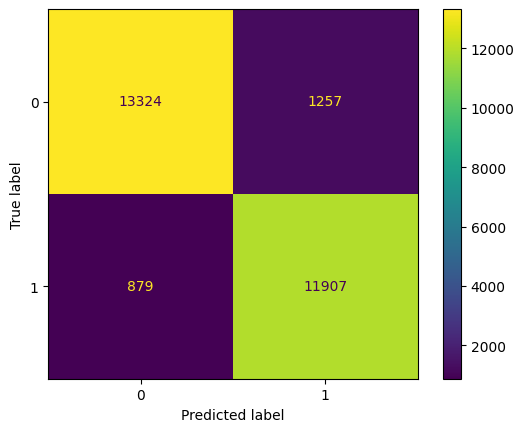

In [272]:
cm_rfc = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rfc)
disp.plot()
plt.show()